In [1]:
from biquad import BiquadFilter
from plot import plot_signals
import numpy as np
import scipy.io.wavfile as wav
import time
import cmath as math
from pynq import allocate

In [2]:
# Calculate Filter Coefficients
def calc_coef(f0, fs, Q):
    # Calculate the angular frequency and alpha
    omega0 = 2 * math.pi * f0 / fs;
    alpha = math.sin(omega0) / (2 * Q);

    # Filter coefficients
    b0 = (1 - math.cos(omega0)) / 2;
    b1 = 1 - math.cos(omega0);
    b2 = (1 - math.cos(omega0)) / 2;
    a0 = 1 + alpha;
    a1 = -2 * math.cos(omega0);
    a2 = 1 - alpha;

    # Normalize coefficients
    b0 = b0 / a0;
    b1 = b1 / a0;
    b2 = b2 / a0;
    a1 = a1 / a0;
    a2 = a2 / a0;

    print(f"a0:\t{a0}\nb0:\t{b0}\nb1:\t{b1}\nb2:\t{b2}\na1:\t{a1}\na2:\t{a2}\n");
    
    return b0, b1, b2, a1, a2

# First, test software implementation

In [3]:
def apply_biquad_filter(wav, sampling_rate):
    # Initialize the filter
    center_freq = 1000
    
    b0, b1, b2, a1, a2 = calc_coef(center_freq, sampling_rate, 20)

    #b0, b1, b2, a1, a2 = 0.2, 2, 0.5, -0.2, 0.5
    filter = BiquadFilter(b0, b1, b2, a1, a2)

    # Process the data through the filter
    return np.array([filter.process_sample(x) for x in wav])

In [4]:
def remove_offset(wav):
    # Convert data to float, normalize, and remove DC offset
    if wav.ndim > 1:  # if stereo, take only the first channel
        wav = wav[:, 0]
    wav = wav.astype(np.float32)
    wav -= np.mean(wav)  # Removing DC offset by subtracting the mean
    return wav

In [5]:
def output_wav(filtered_data, output_filename, sample_rate):
    filtered_data_int16 = np.int16(filtered_data / np.max(np.abs(filtered_data)) * 32767)

    # Write the filtered signal to a new WAV file
    wav.write(output_filename, sample_rate, filtered_data_int16)

    print(f"Filtered signal written to {output_filename}")

In [6]:
input_filename = 'hal_9000.wav'
output_filename = 'output.wav'

# Read the WAV file
sample_rate, data = wav.read(input_filename)

data = remove_offset(data)

a0:	(1.0134887685796545+0j)
b0:	(0.07797171561092814+0j)
b1:	(0.15594343122185628+0j)
b2:	(0.07797171561092814+0j)
a1:	(-1.6614946510020492+0j)
a2:	(0.9733815134457617+0j)

Elapsed Time:	9.468424797058105
Filtered signal written to output.wav


/tmp/ipykernel_4889/1518303373.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  filtered_data_int16 = np.int16(filtered_data / np.max(np.abs(filtered_data)) * 32767)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


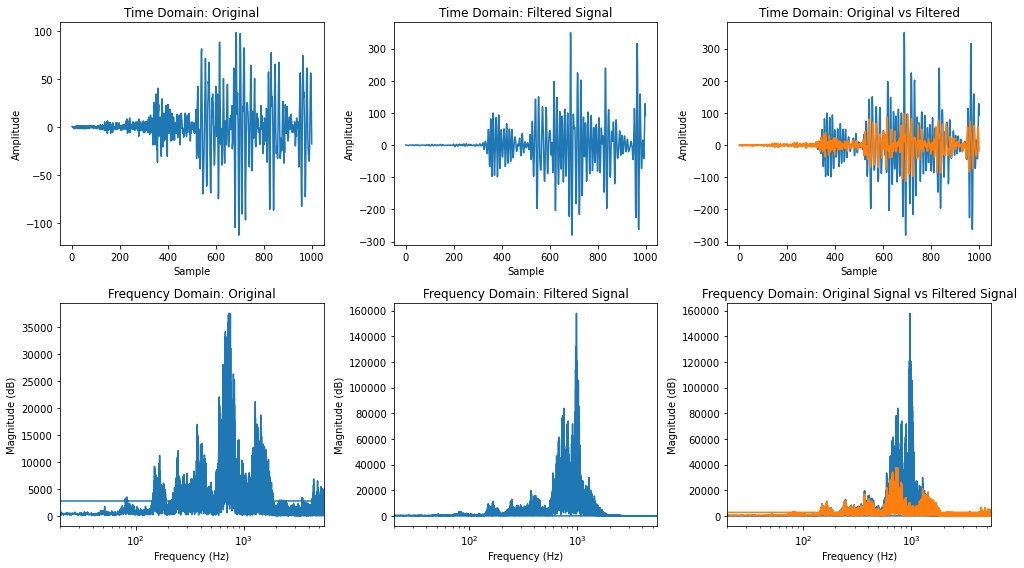

In [7]:
# Apply the filter to the input file
start = time.time()
filtered_data = apply_biquad_filter(data, sample_rate)
end = time.time()

print(f'Elapsed Time:\t{end-start}')

output_wav(filtered_data, output_filename, sample_rate)

plot_signals(data, filtered_data, sample_rate)

# Next, test hardware implementation

In [7]:
from pynq import Overlay

biquad_overlay = Overlay('/home/xilinx/overlays/echoeqv07/echoeqv07.bit')
biquad_overlay?

In [8]:
def conv_float_to_apfixed(val, exp):
    shifted_val = val * (2**exp)
    fixed_val = int(round(shifted_val))
    if shifted_val < 0:
        fixed_val = abs(fixed_val)
        fixed_val = ~fixed_val
        fixed_val = fixed_val + 1
    return fixed_val

def conv_apfixed_to_float(val, exp):
    c = int(abs(val))
    sign = 1 
    if val < 0:
        c = int(val - 1) 
        c = ~c
        sign = -1
    f = (1.0 * c) / (2 ** exp)
    f = f * sign
    return f

In [23]:
# Resize data to play nice with dma buffer sizes
SIZE_OF_BUFFER = 32
print(len(data))

current_length = data.size
# Calculate the remainder when the current length is divided by the buffer size
remainder = current_length % SIZE_OF_BUFFER
# If remainder is not zero, calculate the size needed to make length divisible by buffer size
if remainder != 0:
    new_length = current_length + (SIZE_OF_BUFFER - remainder)
else:
    new_length = current_length  # No resizing needed if already divisible

# Create a new array with the new length, filled with zeros
new_arr = np.zeros(new_length, dtype=data.dtype)
# Copy the original data to the new array
new_arr[:current_length] = data

data = new_arr
print(len(data))

55808
55808


In [33]:
# Calculate new coefficients from center frequency
import struct

center_freq = 1200

b0, b1, b2, a1, a2 = calc_coef(center_freq, sample_rate, 1000)

coef_exp = 13

b0_bytes = struct.pack('f', b0.real)
b1_bytes = struct.pack('f', b1.real)
b2_bytes = struct.pack('f', b2.real)
a1_bytes = struct.pack('f', a1.real)
a2_bytes = struct.pack('f', a2.real)

#biquad_overlay.axi_bram_ctrl_1.write(0, conv_float_to_apfixed(b0.real, coef_exp))
#biquad_overlay.axi_bram_ctrl_1.write(4, conv_float_to_apfixed(b1.real, coef_exp))
#biquad_overlay.axi_bram_ctrl_1.write(8, conv_float_to_apfixed(b2.real, coef_exp))
#biquad_overlay.axi_bram_ctrl_1.write(12, conv_float_to_apfixed(a1.real, coef_exp))
#biquad_overlay.axi_bram_ctrl_1.write(16, conv_float_to_apfixed(a2.real, coef_exp))
biquad_overlay.axi_bram_ctrl_1.write(0, int.from_bytes(b0_bytes, byteorder='little'))
biquad_overlay.axi_bram_ctrl_1.write(4, int.from_bytes(b1_bytes, byteorder='little'))
biquad_overlay.axi_bram_ctrl_1.write(8, int.from_bytes(b2_bytes, byteorder='little'))
biquad_overlay.axi_bram_ctrl_1.write(12, int.from_bytes(a1_bytes, byteorder='little'))
biquad_overlay.axi_bram_ctrl_1.write(16, int.from_bytes(a2_bytes, byteorder='little'))

a0:	(1.0003159042276237+0j)
b0:	(0.1124022141286366+0j)
b1:	(0.2248044282572732+0j)
b2:	(0.1124022141286366+0j)
a1:	(-1.5497595345581365+0j)
a2:	(0.9993683910726828+0j)



In [34]:
dma = biquad_overlay.axi_dma_0
input_buffer = allocate(shape=(SIZE_OF_BUFFER,), dtype='int32')
output_buffer = allocate(shape=(SIZE_OF_BUFFER,), dtype='int32')

filtered_data = np.zeros(len(data))

Elapsed Time:	1.8642606735229492
Filtered signal written to output.wav


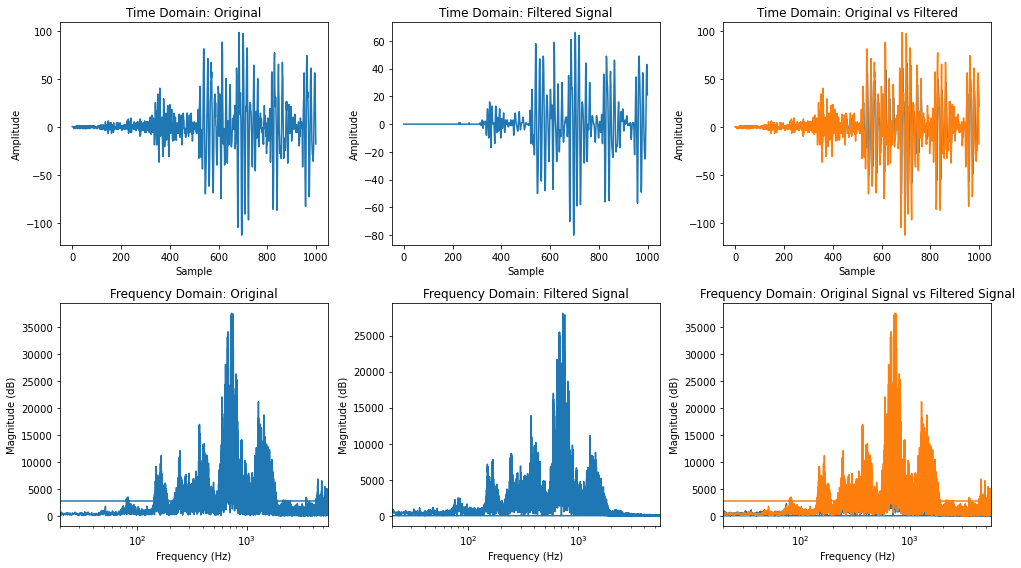

In [35]:
i = 0

# Convert the entire data array to fixed-point format before processing
#data_exp = 4
#data_fixed_point = [conv_float_to_apfixed(x, data_exp) for x in data]

start = time.time()

for i in range(int(len(data) / SIZE_OF_BUFFER)):
    starting_idx = i * SIZE_OF_BUFFER
    input_buffer[:] = data[starting_idx:starting_idx + SIZE_OF_BUFFER].astype(np.int32)
    dma.sendchannel.transfer(input_buffer)
    dma.recvchannel.transfer(output_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    filtered_data[starting_idx:starting_idx + SIZE_OF_BUFFER] = output_buffer[:]
end = time.time()

print(f'Elapsed Time:\t{end-start}')

##filtered_data_float = [conv_apfixed_to_float(x, data_exp) for x in filtered_data]

output_wav(filtered_data, output_filename, sample_rate)

plot_signals(data, filtered_data, sample_rate)